In [230]:
"""import torch
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqModel, self).__init__()

        self.encoder = nn.LSTM(input_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
       

    def forward(self, input_seq, gen_len):
        # Encoder
        _, (encoder_hidden, encoder_cell) = self.encoder(input_seq)

        # Decoder initialization
        decoder_input = torch.zeros(1, input_seq.size(1), self.decoder.input_size)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        output_seq = []

        for _ in range(gen_len):
            output, (decoder_hidden, decoder_cell) = self.decoder(decoder_input, (decoder_hidden, decoder_cell))
            
            output_seq.append(output)

            # Use the predicted output as the input for the next time step
            decoder_input = output

        output_seq = torch.cat(output_seq, dim=1)
        output_seq = self.fc(output_seq)
        return output_seq

# Example usage
input_size = 10  # Size of input vectors
hidden_size = 20  # Size of hidden state
output_size = 10  # Size of output vectors
gen_len = 10

model = Seq2SeqModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example input sequence (batch_size, sequence_length, input_size)
input_sequence = torch.rand((32, 5, input_size))

# Forward pass
output_sequence = model(input_sequence, gen_len)

# Dummy target for illustration purposes
target_sequence = torch.rand((32, gen_len, output_size))

# Compute loss
loss = criterion(output_sequence, target_sequence)

# Backward pass and optimization
optimizer.zero_grad()
loss.backward()
optimizer.step()
"""

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\n\nclass Seq2SeqModel(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(Seq2SeqModel, self).__init__()\n\n        self.encoder = nn.LSTM(input_size, hidden_size)\n        self.decoder = nn.LSTM(hidden_size, hidden_size)\n        self.fc = nn.Linear(hidden_size, output_size)\n       \n\n    def forward(self, input_seq, gen_len):\n        # Encoder\n        _, (encoder_hidden, encoder_cell) = self.encoder(input_seq)\n\n        # Decoder initialization\n        decoder_input = torch.zeros(1, input_seq.size(1), self.decoder.input_size)\n        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell\n\n        output_seq = []\n\n        for _ in range(gen_len):\n            output, (decoder_hidden, decoder_cell) = self.decoder(decoder_input, (decoder_hidden, decoder_cell))\n            \n            output_seq.append(output)\n\n            # Use the predicted output as the input fo

In [231]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import csv
from tqdm import tqdm
import torch.nn.functional as F

In [232]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"


In [233]:
base_path = r'C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\\'

ids_path = 'prepeard_data2.csv'
vocab_path = "vocab.csv"

data_len = 2231142

In [234]:
with open(base_path + vocab_path, 'r') as file:
    vocab = [t[0] for t in list(csv.reader(file))[1:]]

print(vocab)

['<UKN>', '<PAD>', '.', '*', ',', 'and', 'the', '1', 'to', 'in', 'a', '2', 'with', '1/2', ')', '(', 'of', 'cup', 'until', 'add', 'for', 'or', 'c.', 'minutes', 'salt', 'sugar', 'into', 'on', 'pepper', 'heat', '3', 'teaspoon', 'butter', '1/4', 'chopped', 'oil', 'over', 'mix', 'cheese', 'water', ';', 'tsp', 'flour', 'large', 'cups', '4', 'cream', 'tablespoons', 'cook', 'pan', 'bowl', 'mixture', 'stir', 'about', 'onion', 'sauce', 'at', 'bake', 'baking', 'chicken', 'can', 'place', 'garlic', 'is', 'milk', 'tbsp', 'oven', 'it', 'medium', 'cut', 'top', 'eggs', 'brown', 'juice', 'ingredients', 'from', 'combine', 'pour', 'tablespoon', 'well', 'small', 'fresh', 'egg', 'remove', '5', 'serve', '8', 'then', 'vanilla', 'ground', 'cool', 'oz', 'powder', 'cover', '6', '12', 'you', 'each', 'all', '10', 'together', 'if', 'lemon', 'sliced', 'olive', '3/4', 'remaining', 'teaspoons', 'let', 'boil', 'set', 'lb', 'sprinkle', 'green', 'onions', ':', 'taste', 'are', 'hot', 'dough', 'as', 'red', 'ounces', 'tomat

In [235]:

vocab =  vocab + ["<ING>", "<REC>"]



w2id =  {w:i for i,w in  enumerate(vocab)}
id2w =  {i:w for i,w in  enumerate(vocab)}

(w2id)["<REC>"]

10001

In [236]:
import torch
import torch.nn as nn
import torch.optim as optim

class EmbeddingFromMaxIndexFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, prob_vectors, embedding_matrix):
        # Save inputs for backward pass
        ctx.save_for_backward(prob_vectors, embedding_matrix)

        # Find the index of the largest value in each probability vector
        max_indices = torch.argmax(prob_vectors, dim=1).long()

        # Extract the corresponding rows from the embedding matrix
        embeddings = embedding_matrix[max_indices]

        return embeddings

    @staticmethod
    def backward(ctx, grad_output):
        prob_vectors, embedding_matrix = ctx.saved_tensors

        # Find the indices of the largest values in each probability vector
        max_indices = torch.argmax(prob_vectors, dim=1).long()

        # Initialize the gradient for the probability vectors
        grad_prob_vectors = torch.zeros_like(prob_vectors)
        grad_prob_vectors.scatter_(1, max_indices.unsqueeze(1), grad_output)

        # Initialize the gradient for the embedding matrix
        grad_embedding_matrix = torch.zeros_like(embedding_matrix)
        grad_embedding_matrix.index_add_(0, max_indices, grad_output)

        return grad_prob_vectors, grad_embedding_matrix

class EmbeddingFromMaxIndex(nn.Module):
    def __init__(self, embedding):
        embedding_matrix = embedding.weight
        super(EmbeddingFromMaxIndex, self).__init__()
        self.embedding_matrix = embedding_matrix

    def forward(self, prob_vector):
        # Apply the custom function
        embedding = EmbeddingFromMaxIndexFunction.apply(prob_vector, self.embedding_matrix)

        return embedding

# Usage
num_embeddings = 3
embedding_dim = 4

embeding = nn.Embedding(num_embeddings, embedding_dim)
embedding_model = EmbeddingFromMaxIndex(embeding)
probabilities = torch.tensor([[0.1, 0.3, 0.6], [0.1, 0.3, 0.6]], requires_grad=True)

# Define an optimizer
optimizer = optim.SGD([embeding.weight], lr=0.01)

# Forward pass
embedding = embedding_model(probabilities)
print(embedding.shape)
# Loss (you can replace this with your actual loss)
loss = torch.sum(embedding)

print(embeding.weight)
# Backward pass
loss.backward()

# Update the embedding matrix using the optimizer
optimizer.step()
print(embeding.weight)
# Now 'embedding_matrix' has been updated based on the gradients


torch.Size([2, 4])
Parameter containing:
tensor([[-0.2628,  1.0092, -0.5424,  2.4710],
        [ 2.0639, -0.9244, -0.3971, -0.5743],
        [-1.2006, -1.3030, -0.4570,  0.5063]], requires_grad=True)
Parameter containing:
tensor([[-0.2628,  1.0092, -0.5424,  2.4710],
        [ 2.0639, -0.9244, -0.3971, -0.5743],
        [-1.2206, -1.3230, -0.4770,  0.4863]], requires_grad=True)


In [237]:


# Define the Generator
class Generator(nn.Module):
    def __init__(self, vocab_len,hidden_size, depth,max_len):
        EmbeddingFromMaxIndex
        super(Generator, self).__init__()
        
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=depth, batch_first=True)
        self.hidden2vocab = nn.Linear(hidden_size, vocab_len)
        self.hidden_l = nn.Linear(hidden_size * depth, hidden_size)
        self.max_len = max_len
        

        
        

    def forward(self, input_seq):
        original_input = input_seq.clone()
        sequences = self.embedding(input_seq.float())
        outputs = []
        for _ in range(self.max_len):
            next_input, hidden_states = self.singel_pass(sequences)
            outputs.append(next_input)
            sequences = torch.concat((sequences, next_input.unsqueeze(1)), dim = 1)
        outputs = torch.stack(outputs, dim = 1)
        vocab_vectors = self.hidden2vocab(outputs)
        vocab_probs = torch.softmax(vocab_vectors, dim=2)
        out = torch.concat((original_input,vocab_probs), dim=1)
        return out, hidden_states
            
        

    def singel_pass(self, input_seq):
        rand_source = torch.rand((input_seq.shape[0], 1, input_seq.shape[2])).to(device)
        #embedded = torch.concat((rand_source, embedded), dim = 1)
        hidden_states, (last_hidden, _) = self.rnn(input_seq)
        last_hidden = last_hidden.view(1, -1)
        output = self.hidden_l(last_hidden)
        return output, hidden_states


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_len, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input):
        embedded = self.embedding(input)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        output = self.fc(last_hidden)
        prob = F.sigmoid(output)
        return prob, hidden_states

In [238]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [239]:
class CSVDataLoader:
    def __init__(self, csv_file_path, batch_size, num_rows):
        self.csv_file_path = csv_file_path
        self.batch_size = batch_size
        self.num_rows = num_rows
        self.current_index = 0
        self.file_handle = None
        self.csv_writer = None
        self.headers = None

    def open_csv_file(self):
        self.file_handle = open(self.csv_file_path, 'r', newline='')
        self.csv_writer = csv.reader(self.file_handle)
        # Assuming the first row contains headers
        self.headers = next(self.csv_writer)

    def close_csv_file(self):
        if self.file_handle is not None and not self.file_handle.closed:
            self.file_handle.close()

    def reset(self):
        self.close_csv_file()
        self.open_csv_file()
        self.current_index = 0

    def has_next_batch(self):
        return self.current_index < self.num_rows

    def get_next_batch(self, pad):
        ing_batch = [] 
        rec_batch = []
        for _ in range(self.batch_size):
            if not self.has_next_batch():
                break
            ing, rec = next(self.csv_writer)
            ing_batch.append(torch.tensor(eval(ing)).to(device))
            rec_batch.append(torch.tensor(eval(rec)).to(device))
            self.current_index += 1
       
        

        ing_padded = pad_sequence(ing_batch, batch_first=True, padding_value=pad)
        rec_padded = pad_sequence(rec_batch, batch_first=True, padding_value=pad)
        return ing_padded, rec_padded
    
    def batches_left(self):
        return (self.num_rows - self.current_index) // self.batch_size
    
    def __del__(self):
        self.close_csv_file()

In [240]:
for i in range(1,100,10):
    print(F.normalize(torch.tensor([[0.1,0.2,0.5]], dtype=torch.float32) * i, dim = 1))

tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])


In [241]:
def one_hot_noisify_tokens(batch, vocab_len, temperature, diffrance):
    one_hots = torch.nn.functional.one_hot(batch, vocab_len)
    rands = (torch.rand(one_hots.shape))
    rands[one_hots == 1] = 1 + diffrance
    rands = torch.pow(rands + 0.5, temperature)
    noisified = F.normalize(rands, dim = 2)
    return noisified
def one_hot_stats(batch, hot_batch):
    print("Avreg one hot value:",torch.mean(torch.gather(hot_batch, 2, batch.unsqueeze(-1))).item())
    a = torch.topk(hot_batch, 2, )[0]
    print("Avg first and second eq:", (a[:,:,0]==a[:,:,1]).float().mean().item())
    zero_mask = ~(torch.nn.functional.one_hot(batch, hot_batch.shape[-1])== 1)
    #print("Varaiance", torch.mean(torch.var(hot_batch[zero_mask].view(hot_batch.shape[-1],-1), dim = 1)).item())
    
a = torch.tensor([[0,1,2,3]])
b = one_hot_noisify_tokens(a, 4, 20, 0.001)
one_hot_stats(a,b)
print(b)



Avreg one hot value: 0.9447336792945862
Avg first and second eq: 0.0
tensor([[[9.9991e-01, 4.6474e-06, 1.9118e-03, 1.3382e-02],
         [2.5879e-04, 1.0000e+00, 9.0006e-04, 3.4937e-09],
         [1.9134e-03, 3.5762e-05, 9.9984e-01, 1.7615e-02],
         [6.2680e-01, 3.6576e-08, 1.2405e-08, 7.7918e-01]]])


In [242]:
"""args = torch.randint(1,100, (1000, 3))
r = torch.arange(2500).view(50, -1)
for b,c,d in tqdm(args):
    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)
    assert(torch.equal(r, h))"""

'args = torch.randint(1,100, (1000, 3))\nr = torch.arange(2500).view(50, -1)\nfor b,c,d in tqdm(args):\n    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)\n    assert(torch.equal(r, h))'

In [243]:
def patch_batch(ings, start, midel):
    start_tokens = torch.full((ings.shape[0],), start).unsqueeze(1).to(device)
    midel_tokens = torch.full((ings.shape[0],), midel).unsqueeze(1).to(device)
    return torch.cat((start_tokens, ings, midel_tokens), dim=1).to(device)


In [244]:
data_path = r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\prepeard_data.csv"
data_loader = CSVDataLoader(data_path, 32, 2231142)
data_loader.open_csv_file()
d = data_loader.get_next_batch(w2id["<PAD>"])
data_loader.close_csv_file()

patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])[0]

tensor([10000,     3,    67,   206,  1827,    96,     4,    59,   345,     2,
           23,   742,    55,   227,     2,     3,    28,    34,    48,   196,
          103,     2,     3,   483,   117,    34,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1, 10001])

In [245]:
b = patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])
h = one_hot_noisify_tokens(b,len(vocab),
                       50,0.1)
one_hot_stats(b,h)
print(h[1][1][:100])

Avreg one hot value: 0.9003086090087891
Avg first and second eq: 0.0
tensor([3.2566e-21, 2.3942e-13, 1.3376e-18, 3.4589e-22, 3.9672e-08, 8.9957e-01,
        9.7240e-10, 1.7580e-14, 1.6269e-09, 4.0687e-18, 3.0038e-03, 3.5194e-05,
        1.1435e-02, 5.3579e-25, 9.3166e-03, 1.1910e-09, 2.2712e-03, 4.3496e-03,
        1.5821e-03, 1.0147e-06, 3.5149e-06, 3.2991e-17, 3.1620e-24, 6.7699e-04,
        3.6471e-16, 1.2249e-11, 3.2343e-11, 2.4129e-05, 1.2014e-04, 2.9103e-02,
        4.9571e-23, 2.8511e-20, 2.2264e-11, 2.0196e-17, 4.6040e-11, 6.7638e-19,
        7.6208e-07, 1.2764e-04, 2.9360e-16, 7.4756e-13, 1.1598e-22, 1.4908e-02,
        3.8013e-08, 3.1584e-15, 1.1109e-15, 7.1424e-07, 5.3520e-23, 1.2059e-02,
        9.7432e-07, 5.5823e-16, 1.9714e-24, 6.7814e-08, 8.9137e-17, 1.5273e-02,
        2.1741e-20, 1.6792e-22, 4.0832e-22, 2.7516e-19, 3.4317e-03, 1.5958e-21,
        2.9603e-17, 5.1711e-04, 3.8476e-12, 4.2699e-20, 7.8262e-05, 1.2041e-10,
        1.0771e-23, 2.6237e-06, 1.9588e-24, 5.7698e

In [246]:
def topk(next_probs, k):
    topk_values, topk_indices = torch.topk(next_probs, k, dim=1)
    topk_values, topk_indices = topk_values.to(device), topk_indices.to(device)
    topk_index_indices = torch.multinomial(torch.exp(topk_values), 1).squeeze(1).to(device)
    next_tokens = topk_indices[
        torch.arange(topk_index_indices.shape[0]), topk_index_indices]
    return next_tokens

In [247]:
import torch

class CustomArgmaxFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        argmax_indices = torch.argmax(input, dim=-1).to(dtype=torch.float16)
        argmax_indices.requires_grad = True
        return argmax_indices

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        grad_input.scatter_(-1, input.unsqueeze(-1), 1)
        grad_input = grad_input * grad_output.unsqueeze(-1)
        return grad_input

# Usage
x = torch.randn(3, 4, requires_grad=True)
argmax_op = CustomArgmaxFunction.apply
output = argmax_op(x)

# Now, you can use 'output' in your subsequent computations, and it will have gradients
output.requires_grad


True

In [248]:
def topk_generator(generator, sampler, initial_sequence, max_len, stop_token, pad):
    current_sequence = initial_sequence.clone().to(device)
    rec_start = current_sequence.shape[1] - 1
    i = 0
    not_done_indices = torch.arange(current_sequence.shape[0]).to(device)

    while i < max_len and not_done_indices.numel() > 0:
        next_probs, hidden_states = generator(current_sequence[not_done_indices])
        
        next_tokens = sampler(next_probs)

        done_indices = torch.nonzero(torch.eq(next_tokens, stop_token), as_tuple=False).squeeze().to(device)
        not_done_indices = not_done_indices[~torch.isin(not_done_indices, done_indices)]

        next_tokens_column = torch.full((current_sequence.shape[0],), pad).to(device)
        next_tokens_column[not_done_indices] = next_tokens
        next_tokens_column = next_tokens_column.unsqueeze(1)

        current_sequence = torch.cat((current_sequence[:, :-1], next_tokens_column, current_sequence[:, -1:]), dim=1).to(device)

        i += 1

    output_end_tokens = torch.full((current_sequence.shape[0],), pad).to(device)
    output_end_tokens[not_done_indices] = stop_token
    output_end_tokens = output_end_tokens.unsqueeze(1)
    current_sequence = torch.cat((current_sequence[:, :-1], output_end_tokens), dim=1).to(device)

    

    return current_sequence,  hidden_states



In [249]:
class Dummy_loader:
    def __init__(self, d) -> None:
        self.d = d

    def reset(self):
        pass
    def open_csv_file(self):
        pass
    def batches_left(self):
        return 1

    def get_next_batch(self, a):
        return self.d
    

In [250]:
# Hyperparameters
generator_hidden_size = 500
discriminator_hidden_size = 4
#seq_length = 20  # Adjust based on your prompt length
gen_lr  = 1
disc_lr = gen_lr/100
batch_size = 1

k = 1
max_gen_len = 4
epochs = 300



In [252]:
torch.autograd.set_grad_enabled(True)
a = CSVDataLoader(r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\dummy_data.csv", 1, 1)
a.open_csv_file()
pad1 = w2id["<PAD>"]

dummy_loader = Dummy_loader(a.get_next_batch(pad1))
#data_loader = CSVDataLoader(data_path, batch_size, 2231142)


data_loader = dummy_loader


data_loader.open_csv_file()
# Instantiate Generator and Discriminator
generator = Generator(len(vocab), generator_hidden_size, 2, max_gen_len).to(device)
discriminator = Discriminator(len(vocab), discriminator_hidden_size).to(device)


# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=gen_lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

gen_losses = []
real_losses = []
fake_losses = []
avg_real = []
avg_fake = []


for epoch in tqdm(range(epochs)):
    if epoch == 40:
        pass
    data_loader.reset()
    batch_nr = 0
    total_nr_batches = data_loader.batches_left()
    #total_nr_batches =  100
    itr =(range(total_nr_batches))
    for batch_nr in itr:
        # Training the Discriminator
        pad1 = w2id["<PAD>"]
       
   
        real_ingredients, real_recipies = data_loader.get_next_batch(pad1)
        patched_x = patch_batch(real_ingredients, 
                                        w2id["<ING>"],
                                        w2id["<REC>"])
        real_batch_x = torch.nn.functional.one_hot(patched_x, len(vocab))
        patched_y =  real_recipies
        real_batch_y = torch.concat(
            (real_batch_x, one_hot_noisify_tokens(patched_y, len(vocab), 50, 0.1)),dim=1)
        a = real_batch_y.argmax(dim=2)
        #print(real_batch_y)
        generated_recepies, _ = generator(real_batch_x)
        ab = generated_recepies.argmax(dim=2)
        #print(generated_recepies)
        real_output, _ = discriminator(real_batch_y)
        real_output = real_output.squeeze(-1).squeeze(0)
        fake_output, _ = discriminator(generated_recepies.detach())
        fake_output = fake_output.squeeze(-1).squeeze(0)

        real_labels = torch.ones((batch_size, )).to(device)
        fake_labels = torch.zeros((batch_size, )).to(device)
        real_loss = criterion(real_output, real_labels)
        fake_loss = criterion(fake_output, fake_labels)
        disc_loss = real_loss + fake_loss

        avg_real.append(torch.mean(real_output).item())
        avg_fake.append(torch.mean(fake_output).item())

        
        #print("Disc grad")
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
            
        

        # Training the Generator

        
        
       
        #print("Gen grad")
        fake_output, _ = discriminator(generated_recepies)
        fake_output = fake_output.squeeze(-1).squeeze(0)
        real_labels = torch.ones((batch_size, )).to(device)
        gen_loss = criterion(fake_output, real_labels)
        gen_optimizer.zero_grad()
        gen_loss.backward()
        for name, param in generator.named_parameters():
            if param.grad is None:
                print("AAAAAAAAAAAA")
        gen_optimizer.step()

        gen_losses.append(gen_loss.item())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())

    
            

100%|██████████| 300/300 [00:54<00:00,  5.55it/s]


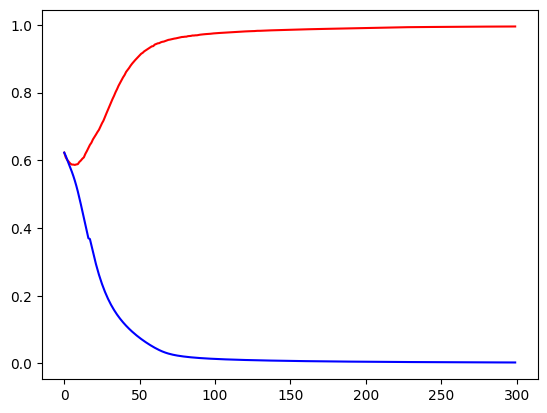

0.002911311574280262

In [253]:
import matplotlib.pyplot as plt
plt.plot(avg_real, color = "red")
plt.plot(avg_fake, color = "blue")
plt.show()
avg_fake[-1]

In [ ]:
print(gen_losses[-1], real_losses[-1], fake_losses[-1])

0.6916722059249878 0.31458649039268494 0.6946316361427307


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def encode(prompt, dic):
    return [dic.get(t.lower(),dic["<UKN>"]) for t in word_tokenize(prompt)]

In [ ]:
encode("1. break milk I brew a cool candy", w2id)

[5182, 733, 64, 209, 3877, 10, 90, 855]

In [ ]:
def decode(answer, dic):
    return " ".join([dic[i] for i in answer])

In [ ]:
decode(encode("we bake a NLP cake", w2id), id2w)

'we bake a <UKN> cake'

In [ ]:
def generate(prompt, generator):
    t = torch.tensor(encode(prompt, w2id)).unsqueeze(0).to(device)
    batch = torch.nn.functional.one_hot(patch_batch(t,
                              w2id["<ING>"],
                              w2id["<REC>"]))
    answer, _ = generator(batch)
    ids = answer[0].argmax(dim=1)
    return decode([int(i) for i in ids], id2w)

In [ ]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
ing, rec ="1 c. firmly packed brown","In a heavy 2-quart"

generator.eval()
with torch.no_grad():
    print((generate(ing, generator)))
print()
print(rec)

<ING> 1 c. firmly packed brown <REC> smokies smokies smokies smokies

In a heavy 2-quart
